In [2]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import os
from dataclasses import dataclass


In [3]:
exp_name = 'EMIL_SW90_f070'
work_path = '/work/bd1022/b381739'
home_path = '/home/b/b381739/'
inpath = f'{work_path}/{exp_name}/postprocessed'
outpath = f'{home_path}/masterarbeit/relax_input_files' 

ds_tequ = xr.open_dataset(f'{outpath}/Tequ_PK4_NH.nc')
ds_pls = xr.open_dataset(f'{inpath}/{exp_name}_pl_sel.nc')

lat = ds_tequ.lat
lon = ds_pls.lon
plev = ds_tequ.plev

lat_rad = np.radians(lat)
lon_rad = np.radians(lon)
ds_tequ

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 1, plev: 90)
Coordinates:
  * plev     (plev) float32 0.9946 3.183 5.808 ... 9.671e+04 9.954e+04 1.009e+05
  * lat      (lat) float32 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * lon      (lon) float32 0.0
Data variables:
    Tequ     (lat, plev, lon) float32 ...

In [4]:
@dataclass
class Params_HS_PK:
    # relaxation time
    ta = 40       # (days) relaxation time outside of tropical troposphere
    ts = 4        # (days) relaxation time at the surface of tropical troposphere
    sigb = 0.7    # sigma level below which a short relaxation time is used in the tropics
    # equilibrium temperature
    hfac = -1      # hemispheric factor, hfac>0 in winter in NH (January), hfac<0 winter in SH (July)
    p0 = 101325   # (Pa) reference pressure
    T0 = 200      # (K) [HS only] minimum equilibrium temperature 
    T1 = 315      # (K) maximum temperature in troposphere
    Ty = 60       # (K) meridional temperature gradient in troposphere
    Tz = 10       # (K) vertical temperature gradient in troposphere
    eps_abs = 10  # (K) absolute value of asymmetry factor in troposphere
    # only PK below
    gammapk = 2     # (km/day) polar vortex lapse rate
    l0_abs = 50   #  absolute value of transition latitude from inversion to polar vortex in stratosphere
                    #  later in messy_relax.f90, the values for x = (eps,l0) are set to:
                    #  x = sign(hfac) * x_abs
    dl = 10       # rapidity of transition from inversion to polar vortex in stratosphere
    pT_SH = 10000 # (Pa) tropopause pressure in summer hemisphere
    pT_WH = 40000 # (Pa) tropopause pressure in winter hemisphere
    # only SW below
    l0 = 0        # latitude of T_equ maximum
    alpha = 3.5   # controls vertical lapse rate of radiative equilibrium state
    # physical parameters
    k = 2/7
    g = 9.81      # (m/s^2)
    R = 287.0     # (J/kg*K)
    ph = 0.1      # top boundary pressure
    # kappa
    tau_a = 50
    tau_s = 7
    sigma_b = 0.85
    p0 = 101325   # (Pa) reference pressure
    

class Forcing_params:
    # tropical convection
    lat_ref = 0
    lat_max = 24.0
    fgamma = 1
    gamma_dry = - 0.0098
    tc = 4
    # tropical upper tropospheric heating
    q0_cct= 0.5    # (K/day)
    lat0_t= 0        # (degree)
    sigma_lat= 0.4 # (rad)
    z0= 0.3        # (/)
    sigma_z= 0.11  # (/)
    butler_heat= True # 
    # tteh waves
    q0=  6           # (K/day)
    m_WN= 2          # (/)
    phi0= 45         # (degree)
    sigma_phi= 0.175 # (rad)
    p_bot= 80000     # (Pa)
    p_top= 20000     # (Pa)
    # monsoon
    pbot= 80000 # (Pa)
    ptop= 10000 # (Pa)
    lat0= 20  # (degree)
    latd= 10
    lon0= 90  # (degree)
    lond= 30
    offset= 8.0 # (K/day)
    amplitude= 0.0 # (K/day)
    heating_period= 15.0 # (days)
    spin_up= 20.0  # (days)
    # kappa field
    tau_amp = 13
    m_WN = 2
    phi0 = 45
    sigma_phi = 0.175
    

params = Params_HS_PK()
forcing_params = Forcing_params()

p_us = np.array([101325.0, 22632.1, 5474.89, 868.019, 110.906, 66.9389, 3.95642, 0.39814, 0.0999])
t_us = np.array([288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65, 187.65, 187.65])
ylims = [1013,1]

def monsoon_forcing_visualization(q, fp):
    
    p_max = q.plev.sel(plev = (fp.pbot**0.5 * fp.ptop**0.5), method='nearest').values

    fig, ax = forcing_plotting_core(q, fp, fp.lon0, fp.lat0, fp.pbot, fp.ptop)
    
    weights_da = weights(q)
    print(f'total sum over forcing: {q_monsoon.weighted(weights_da).sum()}')
    return fig, ax

def wave_forcing_visualization(q, fp):
    
    p_max = q.plev.sel(plev = (fp.p_bot**0.5 * fp.p_top**0.5), method='nearest').values

    fig, ax = forcing_plotting_core(q, fp, 0.25 * (360/fp.m_WN), fp.phi0, fp.p_bot, fp.p_top)
    
    weights_da = weights(q)
    print(f'total sum over forcing: {q.weighted(weights_da).sum()}')
    return fig, ax

def forcing_plotting_core(q, fp, lon, lat, pbot, ptop):
    
    fig, ax = pplt.subplots(ncols=2, share=False)
    p_max = q.plev.sel(plev = (pbot**0.5 * ptop**0.5), method='nearest').values

    q.sel(plev = p_max, method='nearest').plot.contourf(ax=ax[0], levels=20)
    ax[1].plot(q.sel(lon = lon,  lat = lat, method='nearest'), q.plev)
    ax[0].set_title(f'Map at p of max amplitude: {int(p_max/100)} hPa')
    ax[1].set_title('vertical profile')
    
    ax[1].set_xlim([0, fp.q0])
    ax[1].set_ylim([100000, 0])
    
    return fig, ax

def weights(q):
    """
    weighting with pressure in the vertical and cos(lat) in latitude
    """
    plevs = q.plev.values
    if plevs[1] < plevs[0]:
        plevs = np.flipud(plevs)

    vert_weights = np.zeros(plev.size)

    vert_weights[0] = (plevs[1] + plevs[0])/2 - plevs[0]
    vert_weights[1:-1] = (plevs[2:] + plevs[1:-1])/2 - (plevs[1:-1] + plevs[:-2])/2
    vert_weights[-1] = 1013e2 - (plevs[-1] + plevs[-2])/2

    vert_weights = vert_weights/np.sum(vert_weights)

    lat_weights = np.cos(np.radians(q.lat))

    weights = np.outer(vert_weights, lat_weights)
    weights_da = xr.DataArray(weights, dims=['plev', 'lat'], 
                              coords=dict(plev=(['plev'], q.plev.data), 
                                          lat=(['lat'], q.lat.data),))
    return weights_da

def g_func(lon, lon0):
    return np.min(np.array([np.mod((lon-lon0), 360), np.mod((lon0-lon), 360)]), axis=0)

def moist_convection(t, lat, plev, gph, p=params, fp=forcing_params):
        
    lat_weights = 1 - np.tanh( np.sin(np.radians(lat)**2/np.sin(np.radians(fp.lat_max))**2))
    
    dz = np.zeros(plev.shape)
    q_0 = np.zeros(t.shape)
    
    kc = 1 / (fp.tc * 24 * 60 * 60)
    
    for jp,l in enumerate(lat):
        dz[1:] = gph[1:,jp] - gph[:-1,jp]
        t_ma = t[0,jp]
        for jk,z in enumerate(gph):
            t_ma = t_ma + fp.fgamma * fp.gamma_dry * dz[jk]
            if (t_ma < t[jk,jp]):
                break
            q_0[jk,jp] = - lat_weights[jp] * kc * (t[jk,jp] - t_ma)
    
    q_0_da = xr.DataArray(q_0.T, dims=['lat', 'plev'],
                          coords=dict(lat = (['lat'], np.rad2deg(lat)),
                                      plev= (['plev'], plev)))
            
    return q_0_da

def tteh_cc_tropics(lat, plev, p=params, fp=forcing_params):
    
    lats, plevs = np.meshgrid(lat, plev)
        
    q_0 = fp.q0_cct * np.exp(- 0.5 * (np.radians(lats - fp.lat0_t)/fp.sigma_lat)**2
                             - 0.5 * ((plevs/p.p0 - fp.z0)/fp.sigma_z) ** 2)
    
    q_0_da = xr.DataArray(q_0, dims=['plev', 'lat'],
                          coords=dict(lat = (['lat'], lat),
                                      plev= (['plev'], plev)))
    return q_0_da

def tteh_waves(lon, lat, plev, p=params, fp=forcing_params):
    
    lons, lats, plevs = np.meshgrid(lon, lat, plev)

    forcing_area = np.where((plevs < fp.p_bot) & (plevs > fp.p_top))
    
    q_0 = np.zeros(lons.shape)
    q_0[forcing_area] = (fp.q0 * np.sin(fp.m_WN * np.radians(lons[forcing_area]))
                         * np.exp(-0.5 * (np.radians(lats[forcing_area]-fp.phi0)/fp.sigma_phi)**2)
                         * np.sin(np.pi * np.log(plevs[forcing_area]/fp.p_bot)/np.log(fp.p_top/fp.p_bot))**1)
    
    q_0_da = xr.DataArray(q_0, dims=['lat', 'lon', 'plev'],
                          coords=dict(lat = (['lat'], lat),
                                      lon = (['lon'], lon),
                                      plev= (['plev'], plev)))
    return q_0_da

def tteh_mons(lon, lat, plev, p=params, fp=forcing_params):
    """
    up to now only constant in time
    """
    lons, lats, plevs = np.meshgrid(lon, lat, plev)
    g_fct_eval = g_func(lons, fp.lon0)
    
    forcing_p = np.where((plevs < fp.pbot) & (plevs > fp.ptop))
    forcing_lon = np.where(g_fct_eval <= fp.lond)
    
    q_p = np.zeros(lons.shape)
    q_lon = np.zeros(lons.shape)
    
    q_p[forcing_p] =  np.sin(np.pi * np.log(plevs[forcing_p]/fp.pbot)/np.log(fp.ptop/fp.pbot))
    q_lat = np.exp( - ((lats-fp.lat0)/fp.latd)**2)
    q_lon[forcing_lon] = 0.5 * (1 + np.cos(np.pi * g_fct_eval[forcing_lon]/fp.lond)) 
    q_t = 1
    
    q_0 = q_p * q_lat * q_lon * q_t
    
    q_0_da = xr.DataArray(q_0, dims=['lat', 'lon', 'plev'],
                          coords=dict(lat = (['lat'], lat),
                                      lon = (['lon'], lon),
                                      plev= (['plev'], plev)))
    return q_0_da

def kappa_wave_forcing_generation(lon, lat, plev, p=params, fp=forcing_params):
    
    lons, lats, plevs = np.meshgrid(lon, lat, plev)

    forcing_area = np.where(plevs/p.p0 > p.sigma_b)

    kappa_a = 1/(p.tau_a * 24 * 60 * 60)

    kappa_s = 1/(p.tau_s * 24 * 60 * 60) + (1/(fp.tau_amp * 24 * 60 * 60) * np.sin(fp.m_WN * np.radians(lon))
                           * np.exp(-0.5 * (np.radians(lat-fp.phi0)/fp.sigma_phi)**2))

    #kappa = np.where(plev/p.p0 > p.sigma_b, kappa_a + (kappa_s - kappa_a) * (plev/p.p0 - p.sigma_b)/(1 - p.sigma_b) * np.cos(lat)**4, kappa_a)
    da_kappa = xr.DataArray(kappa_a, dims=['lon', 'lat', 'plev'],
                              coords=dict(lat = (['lat'], lat.data),
                                          lon = (['lon'], lon.data),
                                          plev= (['plev'], plev.data)))


    kappa_var = (kappa_s - da_kappa).where(da_kappa.plev/p.p0 > p.sigma_b, other=0) * (plev/p.p0 - p.sigma_b)/(1 - p.sigma_b) * np.cos(np.radians(lat))**4
    da_kappa = da_kappa + kappa_var
    
    return da_kappa

def relax_submodel(setup, lat, plev, p=params, t_us=t_us, p_us=p_us, no_polar_vortex=False):
    """
    provide lat in radians.
    """
    lats, plevs = np.meshgrid(lat, plev)
    
    if setup == 'HS':
        eps = np.sign(p.hfac) * p.eps_abs
        
        t_eq_pr = (p.T1 - p.Ty * np.sin(lats)**2 - eps * np.sin(lats)
                   - p.Tz * np.log(plevs/p.p0) * np.cos(lats)**2) * (plevs/p.p0)**p.k
        t_eq = np.where(t_eq_pr < p.T0, p.T0, t_eq_pr)
        return t_eq
    elif setup == 'PK':
        eps = np.sign(p.hfac) * p.eps_abs
        l0 = np.sign(p.hfac) * p.l0_abs
        t_eq = np.zeros(lats.shape)
        
        # Implement interpolation from US Standard Atmosphere
        interp_us = scipy.interpolate.interp1d(np.log(p_us), t_us)
        
        tt = interp_us(np.log(p.pT_SH))
        
        plev_mod = np.where(plev < p.ph, p.ph, plev)
        
        #fig,ax = pplt.subplots()
        
        for i, l in enumerate(lat):
            sinlat = np.sin(l)
            coslat = np.cos(l)
            
            p_tropopause = (( p.pT_WH - p.pT_SH ) / 2.0 ) * ( 1.0 + np.sign(p.hfac) * np.tanh((np.rad2deg(l) - l0)/p.dl ) ) + p.pT_SH

            if no_polar_vortex:
                weight_function = 0.0
            else:
                weight_function = 0.5 * (1.0 + np.sign(p.hfac) * np.tanh((np.rad2deg(l) - l0)/p.dl))
            
            t_int = interp_us(np.log(plev))
            #ax.plot(t_int, np.log(plev), 'o')
            
            # Calculate the HS temperature for all values first
            t_eq_pr = (p.T1 - p.Ty * np.sin(l)**2 - eps * np.sin(l)
                       - p.Tz * np.log(plev/p.p0) * np.cos(l)**2) * (plev/p.p0)**p.k
            t_eq[:,i] = np.where(t_eq_pr < tt, tt, t_eq_pr)
            
            # Create a helper array containing the values above the tropopause
            p_atp = plev < p_tropopause
            
            t_pv = tt*(plev_mod[p_atp]/p_tropopause)**(-p.R*p.gammapk*(-1.0*1e-3)/p.g)
            
            t_eq[p_atp,i] = (1.0 - weight_function) * t_int[p_atp] + weight_function*t_pv
        
        return t_eq
    
    elif setup == 'SW':
        t_sfc = p.T1 - p.Ty * (np.sin(lats)**2 - 2*np.sin(np.radians(p.l0))*np.sin(lats))
        d_0 = (t_sfc/p.T0)**4 - 1
        t_eq = p.T0 * (1 + d_0 * (plevs/p.p0)**p.alpha)**0.25
        return t_eq
        
    raise NotImplementedError

#@interact(T1=(250,350), gammapk=(0, 10))
def adjust_compute_plot(T1=(315), gammapk=(2), eps_abs=(10), l0=(0)):
    params = Params_HS_PK()
    params.T1 = T1
    params.gammapk = gammapk
    params.eps_abs = eps_abs
    params.l0 = l0
    
    t_eq = relax_submodel(setup, lat_rad, plev, params)
    
    fig, ax = pplt.subplots()
    if setup == 'HS' or 'SW':
        t_min, t_max = params.T0, params.T1
    elif setup == 'PK':
        t_min, t_max = params.T0 - params.gammapk * 60, params.T1
        #ax.set_yscale('log')
    else:
        raise NotImplementedError
    
    r_air = 287
    cp = 1003
    theta = (t_eq.T * (101300/plev) ** (r_air/cp)).T

    ax.contourf(lat, plev/100, t_eq, levels=np.arange(t_min, t_max+1, 10),  cmap = 'thermal',  colorbar='r')
    #ax.contour(lat, plev/100, t_eq_HS, levels=np.arange(t_min, t_max, 10), color='k', labels=True, precision=2, lw=1)
    ax.set_xlabel('Latitude [°N]')
    ax.set_ylabel('Pressure [hPa]')
    #ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
    if save_fig:
        fig.save(f't_eq_{setup}_setup.{plot_format}')
   

In [4]:
da_kappa = kappa_wave_forcing_generation(lon, lat, plev)

ds_kappa = da_kappa.reindex(lat=da_kappa.lat[::-1]).to_dataset(name='kappa').transpose('plev','lon','lat')
ds_kappa

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, plev: 90)
Coordinates:
  * lat      (lat) float32 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * plev     (plev) float32 0.9946 3.183 5.808 ... 9.671e+04 9.954e+04 1.009e+05
Data variables:
    kappa    (plev, lon, lat) float64 2.315e-07 2.315e-07 ... 2.315e-07

In [7]:
ds_kappa.to_netcdf(f'relax_input_files/Kappa_sfc_w2_{forcing_params.tau_amp}_amp.nc')

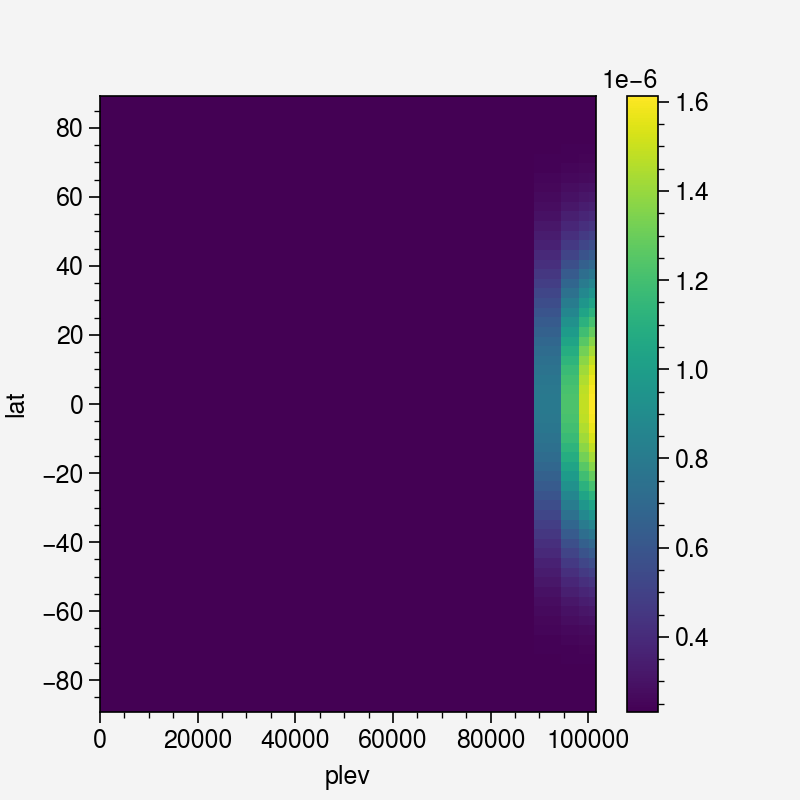

In [74]:
da_kappa.mean('lon').plot()

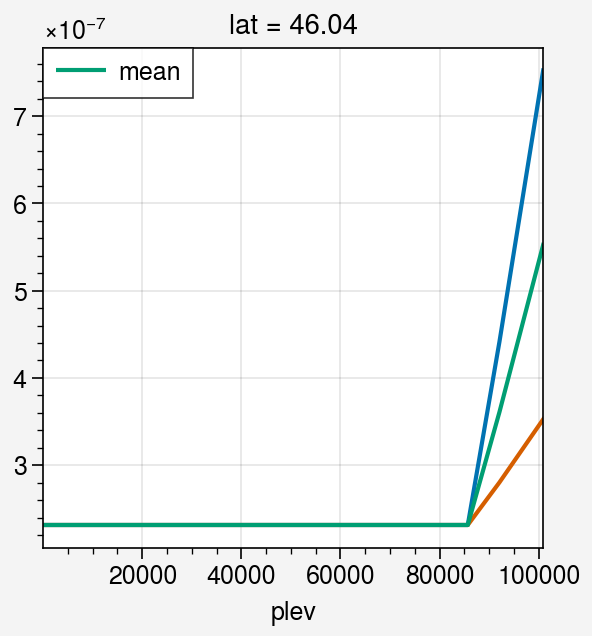

In [75]:
fig, ax = pplt.subplots()

da_kappa.sel(lon=45, lat=45, method='nearest').plot(ax=ax)
da_kappa.sel(lon=135, lat=45, method='nearest').plot(ax=ax)
da_kappa.sel(lat=45, method='nearest').mean('lon').plot(ax=ax, label='mean')
plt.legend()

In [7]:
params.T0 = 200
params.T1 = 350
params.Ty = 90

tequ_SW = relax_submodel('SW', lat_rad, plev)

tequ_SW_expanded = np.expand_dims(tequ_SW.T, axis=2)
tequ_SW_expanded = tequ_SW_expanded.repeat(ds_pls.lon.size, axis=2)

da_tequ_SW = xr.DataArray(tequ_SW_expanded, dims=['lat', 'plev', 'lon'],
                          coords=dict(lat = (['lat'], lat.data),
                                      plev= (['plev'], plev.data),
                                      lon= (['lon'], lon.data)))
"""
da_tequ_SW = xr.DataArray(tequ_SW.T, dims=['lat', 'plev'],
                          coords=dict(lat = (['lat'], lat.data),
                                      plev= (['plev'], plev.data),
                                     )
)
"""

ds_tequ_SW = da_tequ_SW.to_dataset(name='tequ')
#ds_tequ_SW.tequ.mean('lon').T.plot.contourf(levels=15)
#plt.ylim([100000, 1000])

In [97]:
ds_tequ_SW['plev'] = ds_tequ_SW.plev.assign_attrs({'axisType':'Pressure'})
ds_tequ_SW['plev'] = ds_tequ_SW.plev.assign_attrs({'axis':'Z'})
#ds_tequ_SW['lon'] = ds_tequ_SW.lon.assign_attrs({'axisType':'Lon'})
#ds_tequ_SW['lon'] = ds_tequ_SW.lon.assign_attrs({'axis':'X'})
ds_tequ_SW['lat'] = ds_tequ_SW.lat.assign_attrs({'axisType':'Lat'})
ds_tequ_SW['lat'] = ds_tequ_SW.lat.assign_attrs({'axis':'Y'})

ds_tequ_SW['tequ'] = ds_tequ_SW.tequ.assign_attrs({'long_name':'equilibrium temperature'})
ds_tequ_SW['tequ'] = ds_tequ_SW.tequ.assign_attrs({'units':'K'})


In [9]:
ds_tequ_SW

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, plev: 90)
Coordinates:
  * lat      (lat) float32 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * plev     (plev) float32 0.9946 3.183 5.808 ... 9.671e+04 9.954e+04 1.009e+05
  * lon      (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    tequ     (lat, plev, lon) float64 200.0 200.0 200.0 ... 259.5 259.5 259.5

In [8]:
ds_tequ_SW.to_netcdf(f'relax_input_files/Tequ_SW_dy90.nc')